# 代表的な自然言語処理; 日本語, mecabコード編
- [補足説明](./typical_methods.md)
- mecabによる形態素解析
    - 出力オプションの例
    - ノード単位で処理し、原型取得する例
- NLTKの利用
    - KWIC（もしくはKWIC index）
    - コロケーション（collocations）
    - 単語の出現頻度順
    - 単語の条件付き出現頻度
- KNPによる係り受け解析
    - 文節単位での処理例
    - 係り受けを利用したクエリ検索例

## 環境構築
- 形態素解析ツール: mecab
  - 形態素解析用辞書: Neologd
- 係り受け解析ツール: KNP
  - 内部で利用するための形態素解析システム: JUMAN (JUMAN++ではない)斜体テキスト

In [1]:
!date

# 1. MeCab と 辞書(mecab-ipadic-NEologd)のインストール
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc


# 2. NLTKインストール
!pip install nltk

import nltk
nltk.download('stopwords')

# 3. データセット用意
# データ準備
# https://newtechnologylifestyle.net/711-2/
# momotaro.txtは、上記を使ってルビを除外したもの。
!curl -O https://raw.githubusercontent.com/naltoma/datamining_intro/master/3-nlp/corpus/momotaro.txt
!mkdir corpus
!mv momotaro.txt corpus/
filename = "./corpus/momotaro.txt"

# 4. matplotlib で日本語フォントを使うための環境構築
!pip install japanize-matplotlib

# 5. JUMAN
!wget "http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/juman/juman-7.01.tar.bz2"
!bzip2 -dc juman-7.01.tar.bz2 | tar xvf - >& /dev/null
%cd juman-7.01/
!./configure >& /dev/null
!make >& /dev/null
!make install >& /dev/null
%cd ..
!ldconfig

# 6. KNP
!wget http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/knp/knp-4.19.tar.bz2
!tar jxvf knp-4.19.tar.bz2 >& /dev/null
%cd knp-4.19
!./configure >& /dev/null
!make >& /dev/null
!make install >& /dev/null
%cd ..

!pip install pyknp
!date

Mon Apr 12 12:59:41 UTC 2021
Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16575  100 16575    0     0   126k      0 --:--:-- --:--:-- --:--:--  126k
     |████████████████████████████████| 4.1MB 4.5MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=695ba8dd02c88edb5bf0d29dde9f054c5de6f45ef70a99fdf33428c00c7629cd
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Success

## 形態素解析

In [2]:
# 形態素解析
# 辞書により解析結果(推定結果)が変わる
import MeCab
tagger = MeCab.Tagger() #デフォルト辞書利用
print(tagger.parse("すもももももももものうち"))

print('----')

# Neologd利用
path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
tagger = MeCab.Tagger(path)
print(tagger.parse("すもももももももものうち"))

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
EOS

----
すもももももももものうち	名詞,固有名詞,一般,*,*,*,すもももももももものうち,スモモモモモモモモノウチ,スモモモモモモモモノウチ
EOS



In [3]:
# MeCab.Tagger() 時の出力オプションで、パース結果が変わる。
# parse() は単に文字列出力する。オプションは mecab --help で調べよう。
tagger = MeCab.Tagger('-Ochasen ' + path)
print(tagger.parse("すもももももももものうち"))

print('----')

tagger = MeCab.Tagger('-Owakati ' + path)
print(tagger.parse("すもももももももものうち"))

すもももももももものうち	スモモモモモモモモノウチ	すもももももももものうち	名詞-固有名詞-一般		
EOS

----
すもももももももものうち 



In [4]:
# parseToNode() を使うと、ノード単位で処理しやすい。
import MeCab
tagger = MeCab.Tagger(path)

sentence = "おじいさんは山へしば刈かりに、おばあさんは川へ洗濯せんたくに行きました。"
node = tagger.parseToNode(sentence)
while node:
   features = node.feature.split(",")
   original = features[6]
   print('node.surface={}, node.feature={} => original = {}'.format(node.surface,node.feature,original))
   node = node.next


node.surface=, node.feature=BOS/EOS,*,*,*,*,*,*,*,* => original = *
node.surface=おじいさん, node.feature=名詞,一般,*,*,*,*,おじいさん,オジイサン,オジーサン => original = おじいさん
node.surface=は, node.feature=助詞,係助詞,*,*,*,*,は,ハ,ワ => original = は
node.surface=山, node.feature=名詞,一般,*,*,*,*,山,ヤマ,ヤマ => original = 山
node.surface=へ, node.feature=助詞,格助詞,一般,*,*,*,へ,ヘ,エ => original = へ
node.surface=しば, node.feature=名詞,一般,*,*,*,*,しば,シバ,シバ => original = しば
node.surface=刈, node.feature=名詞,一般,*,*,*,*,刈,カリ,カリ => original = 刈
node.surface=かりに, node.feature=副詞,一般,*,*,*,*,かりに,カリニ,カリニ => original = かりに
node.surface=、, node.feature=記号,読点,*,*,*,*,、,、,、 => original = 、
node.surface=おばあさん, node.feature=名詞,一般,*,*,*,*,おばあさん,オバアサン,オバーサン => original = おばあさん
node.surface=は, node.feature=助詞,係助詞,*,*,*,*,は,ハ,ワ => original = は
node.surface=川, node.feature=名詞,一般,*,*,*,*,川,カワ,カワ => original = 川
node.surface=へ, node.feature=助詞,格助詞,一般,*,*,*,へ,ヘ,エ => original = へ
node.surface=洗濯, node.feature=名詞,サ変接続,*,*,*,*,洗濯,センタク,センタク => original = 洗濯
node.surf

## コンコーダンス（語句集）

In [5]:
# concordance

with open(filename, "r") as fh:
    sentences = ""
    for line in fh.readlines():
        sentences += line + " "

def tokenize(sentences):
    """文章を分かち書きする。

    :param sentences(str): 複数の文章を含む文字列。日本語想定。
    :return(list): 分かち書きした単語をlistとしてまとめたもの。
    """

    # 「。」、「！」、「？」で終わる一連の文字列を文として認識し分割する。
    jp_sent_tokenizer = nltk.RegexpTokenizer(u'[^　「」！？。]*[！？。]')
    tagger = MeCab.Tagger('-Owakati ' + path)

    sents = jp_sent_tokenizer.tokenize(sentences)
    tokens = []
    for sent in sents:
        for word in tagger.parse(sent).split(" "):
            if word == " " or word == "\n":
                continue
            tokens.append(word)
    return tokens

tokens = tokenize(sentences)
text = nltk.Text(tokens)
print('\n# nltk.Text.concordance with "おじいさん"')
text.concordance("おじいさん")


# nltk.Text.concordance with "おじいさん"
Displaying 17 of 17 matches:
                                     おじいさん と おばあさん が あり まし た 。 まいにち 、 おじいさん は 山
                                     おじいさん は 山 へ しば刈り に 、 おばあさん は 川 へ 洗濯 に 行き ま
 来 まし た 。 おやおや 、 これ は みごと な 桃 だ こと 。 おじいさん へ の おみやげ に 、 どれどれ 、 うち へ 持っ て 帰り ましょ
い ながら 、 おばあさん の 前 へ 流れ て 来 まし た 。 早く おじいさん と 二人 で 分けて 食べ ましょ う 。 と 言っ て 、 桃 を ひ
 て お うち へ 帰り まし た 。 夕方 に なっ て やっ と 、 おじいさん は 山 から しば を 背負っ て 帰っ て 来 まし た 。 おばあさ
っ て 来 まし た 。 おばあさん 、 今 帰っ た よ 。 おや 、 おじいさん 、 おか いん なさい 。 待っ て い まし た よ 。 さあ 、 早
だ ね 、 その いい もの という の は 。 こう いい ながら 、 おじいさん は わらじ を ぬい で 、 上 に 上がり まし た 。 ほら 、 ご
赤さん が 元気 よく とび出 し まし た 。 おやおや 、 まあ 。 おじいさん も 、 おばあさん も 、 びっくり し て 、 二人 いっしょ に 声
 神さま が この 子 を さずけ て 下さっ た に ちがい ない 。 おじいさん も 、 おばあさん も 、 うれし がっ て 、 こう 言い まし た 
 、 うれし がっ て 、 こう 言い まし た 。 そこで あわて て おじいさん が お湯 を わかす やら 、 おばあさん が むつき を そろえる や
いう ので 、 この 子 に 桃太郎 という 名 を つけ まし た 。 おじいさん と おばあさん は 、 それ は それ は だいじ に し て 桃太郎 
くらい でし た が 、 その くせ 気だて はごく やさしくっ て 、 おじいさん と おばあさん に 

## コロケーション（連語）

In [6]:
# collocation

print("\n# nltk.Text.collocations")
print("## default")
text.collocations()

print("\n## collocations(window_size=5)")
text.collocations(window_size=5)


# nltk.Text.collocations
## default
ドンブラ コッコ; いかめしい くろがね; さけび ながら

## collocations(window_size=5)
コッコ スッコッコ; ドンブラ コッコ; ドンブラ スッコッコ; おじいさん おばあさん; どちら おいで; 鬼が島 せいばつ; 日本一
きびだんご; ござい 日本一; こっこ こっこ; いつまでも 見送っ; ぎゅうぎゅう 押さえつけ; たずね 鬼が島; きびだんご もらっ;
いかめしい くろがね; 下さい ましょ; きびだんご 下さい; 見える 見える; キャッ キャッ; コッコ ドンブラ; スッコッコ コッコ


## 単語の出現頻度


# FreqDist
[('、', 252), ('。', 178), ('た', 119), ('て', 116), ('まし', 92), ('に', 86), ('を', 82), ('と', 76), ('の', 74), ('は', 73), ('が', 46), ('で', 29), ('桃太郎', 29), ('し', 27), ('も', 27), ('へ', 21), ('から', 20), ('だ', 19), ('おじいさん', 17), ('おばあさん', 16), ('う', 16), ('ます', 16), ('鬼', 16), ('言い', 15), ('来', 13), ('ながら', 13), ('お', 12), ('い', 12), ('な', 10), ('もの', 10)]


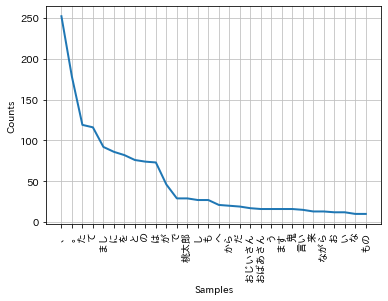

In [7]:
# 単語の出現頻度順

print("\n# FreqDist")
fdist = nltk.FreqDist(tokens)
check_num = 30
print(fdist.most_common(check_num))

%matplotlib inline
import japanize_matplotlib
fdist.plot(check_num)


## bi-gram


# FreqDist with bigram (2-gram)
[(('まし', 'た'), 92), (('た', '。'), 91), (('て', '、'), 48), (('。', 'と'), 31), (('は', '、'), 24), (('と', '、'), 17), (('し', 'て'), 14), (('。', '桃太郎'), 14), (('ながら', '、'), 13), (('に', '、'), 12), (('う', '。'), 11), (('言い', 'まし'), 11), (('桃太郎', 'は'), 11), (('て', 'い'), 10), (('ます', '。'), 10), (('て', '来'), 9), (('ましょ', 'う'), 9), (('で', '、'), 9), (('来', 'まし'), 8), (('を', 'し'), 8), (('、', '桃太郎'), 8), (('、', 'おじいさん'), 7), (('と', 'おばあさん'), 7), (('言っ', 'て'), 7), (('も', '、'), 7), (('から', '、'), 7), (('に', 'なり'), 7), (('だ', '。'), 7), (('よし', '、'), 7), (('桃太郎', 'さん'), 7)]


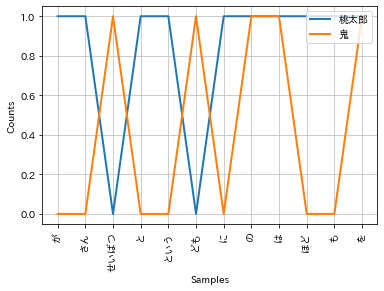

In [8]:
# bigram
print("\n# FreqDist with bigram (2-gram)")
bigrams = nltk.bigrams(tokens)
bigrams_fdist = nltk.FreqDist(bigrams)
print(bigrams_fdist.most_common(check_num))

# conditional FreqDist
cfd = nltk.ConditionalFreqDist(bigrams_fdist)
cfd.plot(conditions=["桃太郎", "鬼"])


## 係り受け解析＋格解析

In [9]:
# KNP on terminal command

!echo "お爺さんは山へ芝刈りに、お婆さんは川へ洗濯に行きました。" | juman | knp

# S-ID:1 KNP:4.19-CF1.1 DATE:2021/04/12 SCORE:-1054.00784
お爺さんは─────┐　　　　　　　　　<体言>
      山へ─────┤　　　　　　　　　<体言>
        芝刈りに、<P>──┐　　　　　<体言>
お婆さんは─────┐　　　 │　　　　　<体言>
      川へ─────┤　　　 │　　　　　<体言>
            洗濯に<P>─PARA─────┐　<体言><用言:動><格解析結果:ガ/婆さん;ニ/川>
                      行きました。<用言:動><格解析結果:ガ/-;ヲ/-;ニ/-;デ/-;カラ/-;マデ/-;ヘ/-;時間/-;ノ/->
EOS


In [10]:
# KNP：文節単位での処理

from pyknp import KNP

knp = KNP(jumanpp=False)
sentence = "お爺さんは山へ芝刈りに、お婆さんは川へ洗濯に行きました。"
result = knp.parse(sentence)

print("文節単位での処理")
for bnst in result.bnst_list(): # 各文節へのアクセス
    print("\tID:%d, 見出し:%s, 係り受けタイプ:%s, 親文節ID:%d, 素性:%s" \
            % (bnst.bnst_id, "".join(mrph.midasi for mrph in bnst.mrph_list()), bnst.dpndtype, bnst.parent_id, bnst.fstring))


文節単位での処理
	ID:0, 見出し:お爺さんは, 係り受けタイプ:D, 親文節ID:2, 素性:<文頭><ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素><正規化代表表記:爺さん/じいさん><主辞代表表記:爺さん/じいさん>
	ID:1, 見出し:山へ, 係り受けタイプ:D, 親文節ID:2, 素性:<ヘ><助詞><体言><一文字漢字><係:ヘ格><区切:0-0><格要素><連用要素><正規化代表表記:山/さん?山/やま><主辞代表表記:山/さん?山/やま>
	ID:2, 見出し:芝刈りに、, 係り受けタイプ:P, 親文節ID:5, 素性:<サ変><ニ><読点><助詞><体言><係:ニ格><並キ:名:&ST:4.0&&ニ><区切:0-4><読点並キ><並列タイプ:？><格要素><連用要素><正規化代表表記:芝刈り/しばかり><主辞代表表記:芝刈り/しばかり><並列類似度:7.576><並結句数:2><並結文節数:3>
	ID:3, 見出し:お婆さんは, 係り受けタイプ:D, 親文節ID:5, 素性:<ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素><正規化代表表記:婆さん/ばあさん><主辞代表表記:婆さん/ばあさん>
	ID:4, 見出し:川へ, 係り受けタイプ:D, 親文節ID:5, 素性:<ヘ><助詞><体言><一文字漢字><係:ヘ格><区切:0-0><格要素><連用要素><正規化代表表記:川/かわ><主辞代表表記:川/かわ>
	ID:5, 見出し:洗濯に, 係り受けタイプ:D, 親文節ID:6, 素性:<サ変><ニ><助詞><体言><係:連用><レベル:A><区切:0-5><ID:〜に><用言:動><サ変動詞化><連用要素><連用節><動態述語><正規化代表表記:洗濯/せんたく><主辞代表表記:洗濯/せんたく>
	ID:6, 見出し:行きました。, 係り受けタイプ:D, 親文節ID:-1, 素性:<文末><時制-過去><句点><用言:動><レベル:C><区切:5-5><ID:（文末）><係:文末><提題受:30><主節><格要素><連用要素><動態述語><敬語:丁寧表現><正規化代表表記:行く/いく><主辞代表表記:行く/いく>


## 係り受け解析を利用したクエリ検索の例

In [11]:
# 係り受けを利用したクエリ検索例

def find_children(parse_result, parent_id):
    """KNPパース結果に対し、parent_id以下の子ノード情報を取得する。

    :param parse_result(pyknp.knp.blist.BList): KNP.parse()した結果。
    :param parent_id(int): 出発点となるID。
    :return:
      children_ids(list): parent_idを親とする子ノードのID一覧。
      children_surfaces(list): children_idsに対応したsurface一覧。
    """
    children_ids = []
    children_surfaces = []
    for child_id, bnst in enumerate(parse_result.bnst_list()):
        if bnst.parent_id == parent_id:
            children_ids.append(child_id)
            surface = "".join(mrph.midasi for mrph in bnst.mrph_list())
            children_surfaces.append(surface)
    return children_ids, children_surfaces

def search(parse_result, user_query):
    """KNPパース結果に対し、ユーザクエリに該当するノード情報を取得する。
    複数該当ノードがある場合には、最初に見つかったノードのみを返す。

    :param parse_result(pyknp.knp.blist.BList): KNP.parse()した結果。
    :param user_query(str): 探したい単語。
    :return:
      children_ids(list): parent_idを親とする子ノードのID一覧。
      children_surfaces(list): children_idsに対応したsurface一覧。
    """
    for id, bnst in enumerate(result.bnst_list()):
        surface = "".join(mrph.midasi for mrph in bnst.mrph_list())
        if user_query in surface:
            children_ids, children_surfaces = find_children(result, id)
            return children_ids, children_surfaces
    return None, None

user_query = "芝刈り"
print('\n# user_query = {}'.format(user_query))

children_ids, children_surfaces = search(result, user_query)
for i in range(len(children_ids)):
    print("child: id={}, surface={}".format(children_ids[i], children_surfaces[i]))



# user_query = 芝刈り
child: id=0, surface=お爺さんは
child: id=1, surface=山へ


In [12]:
!date

Mon Apr 12 13:09:55 UTC 2021
